In [6]:
from calibrate_camera import *
from thresholding import *
from perspective_transform import *
from lane_finding import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Calibrate image given chessboard images

The code for the camera calibration can be found in `calibrate_camera.py`. Given a set of chessboard images taken from the same camera as the one on used on the self-driving car, 

The OpenCV function cv2.findChessboardCorners returns corners detected from the input chessboard images, which we use to append the imgpoints and objpoints.

These imgpoints and objpoints are used to undistorted the original input image. The result of the undistorted image after this step being applied on the original chessboard image and a sample input image from the car.

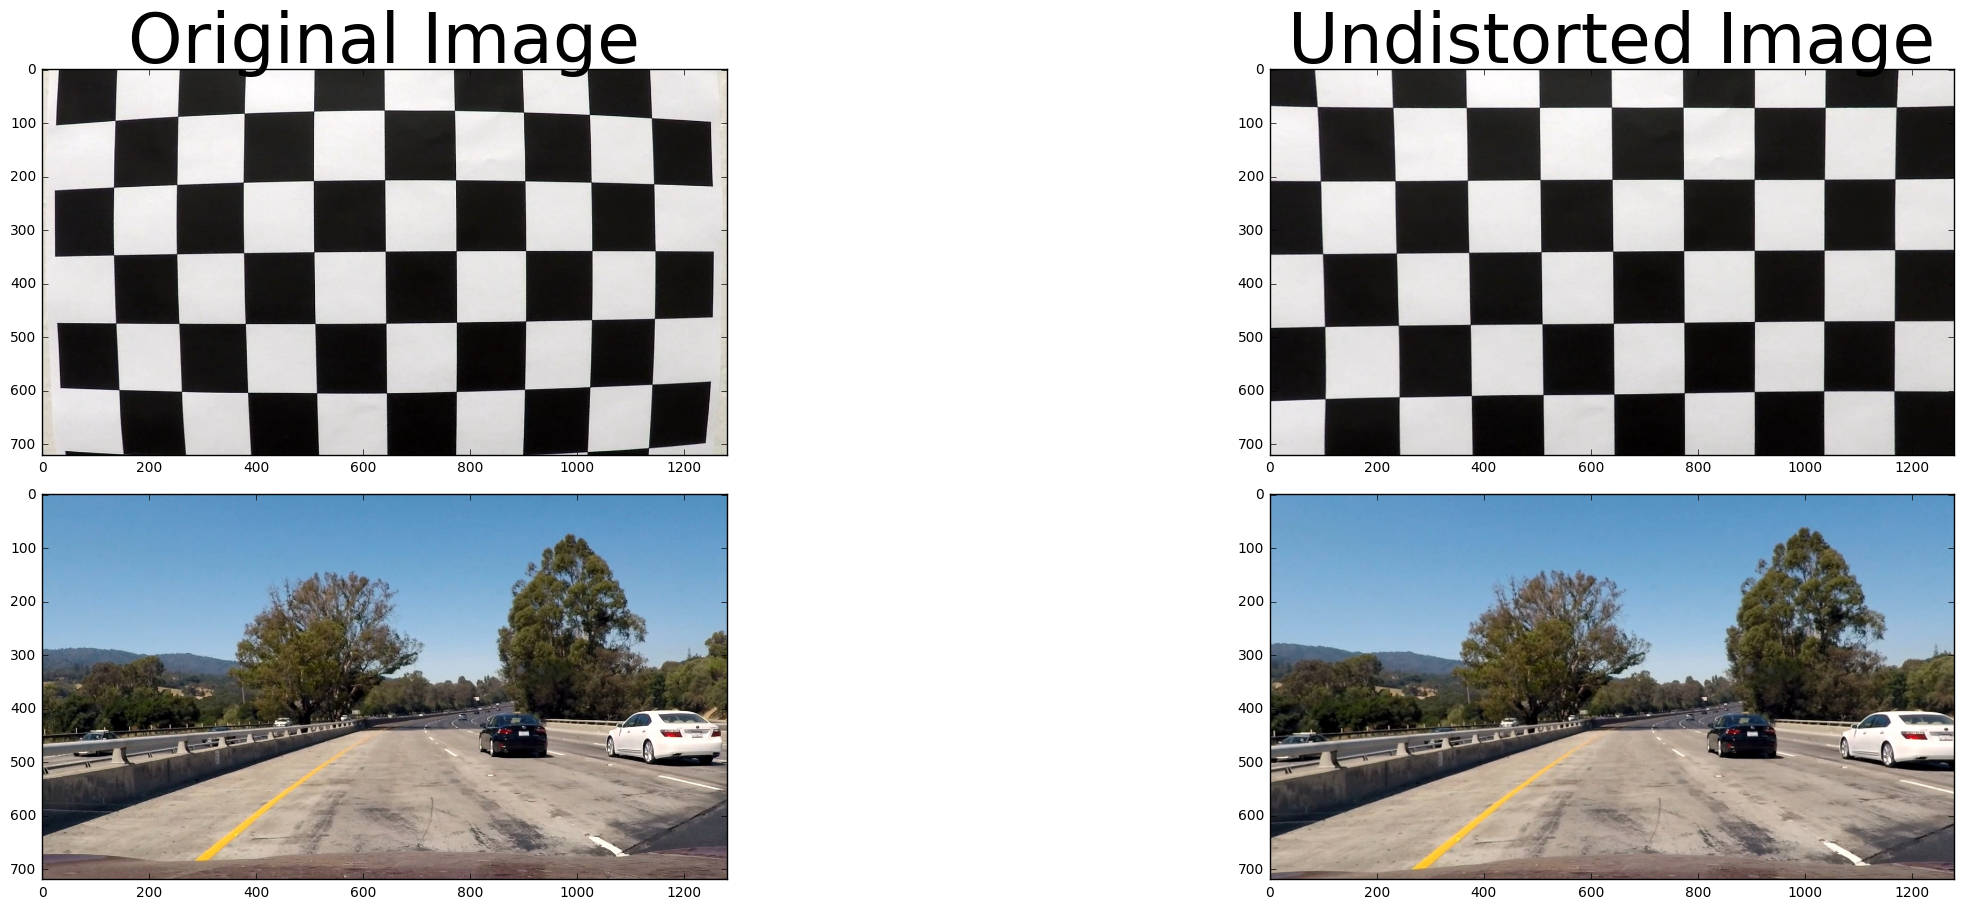

In [7]:
calibration_imgfolder = './camera_cal/'
imgpoints, objpoints = calibrate_pts(calibration_imgfolder)

img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = undistort(img, imgpoints, objpoints)

f, axarr = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
axarr[0, 0].imshow(img)
axarr[0, 0].set_title('Original Image', fontsize=50)
axarr[0, 1].imshow(undistorted)
axarr[0, 1].set_title('Undistorted Image', fontsize=50)

img = mpimg.imread('./test_images/test1.jpg')
undistorted = undistort(img, imgpoints, objpoints)

axarr[1, 0].imshow(img)
axarr[1, 1].imshow(undistorted)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# 2. Binary thresholded image

After undistorting the image, the next step is to use color transforms and gradients to create a thresholded binary image that will help to detect the lines. As seen in `thresholding.py`, a combination of gradient thresholding (in both x and y), gradient magnitude thresholding and the S channel thresholding was used. The S channel from the HLS space was the best to highlight the lane lines on the road.

The combined thresholded binary image is applied to the input image and shown below

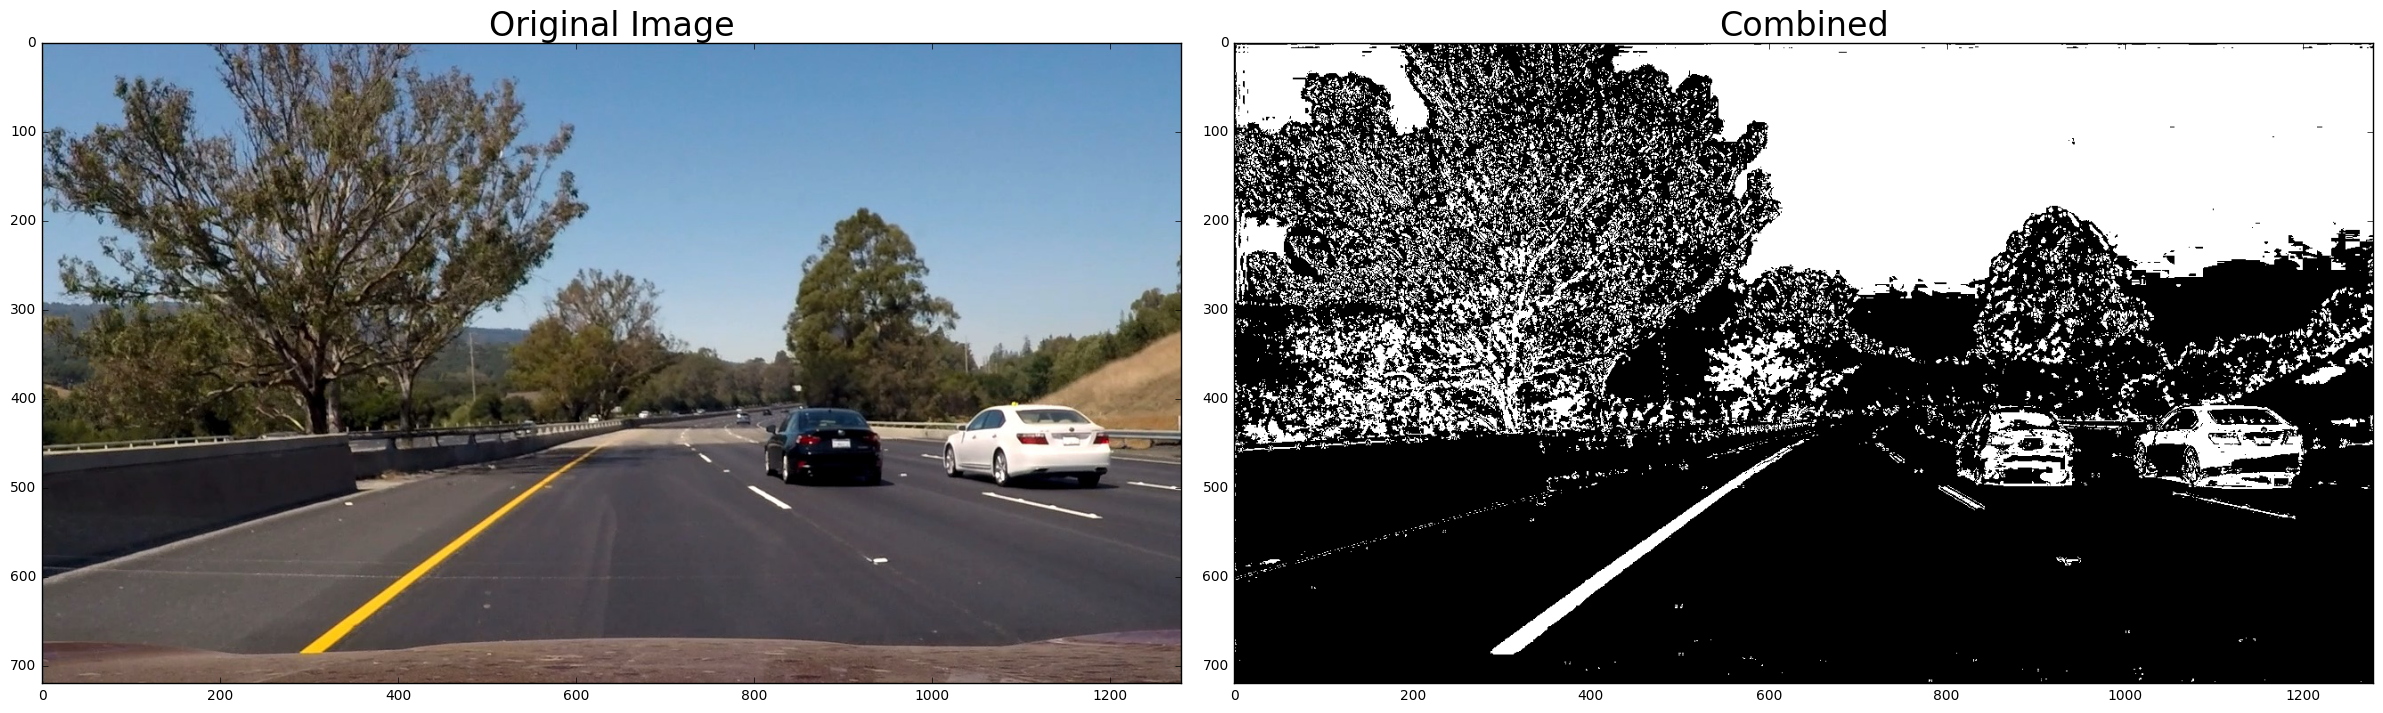

In [8]:
img = mpimg.imread('./test_images/test6.jpg')
binary_output = combine_thresh(img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=24)

ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Combined', fontsize=24)

## 3. Apply perspective transform

The next step is to perform a perspective transform of the image which will give a bird's eye view of the road. The code for this part can be found in `perspective_transform.py`. A matrix M is obtained by mapping 4 points from the original image to new destination points where the lane should flattened to. This matrix M is used by OpenCV's cv2.warpPerspective() to apply the transform and map the source points to the destination points.

The source and destination points were hard-coded and taken from Project 4's write up.

```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0], 
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   |   
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        |
| 203, 720      | 320, 720      |   
| 1127, 720     | 960, 720      |   
| 695, 460      | 960, 0        |

This mapping gave good results, as shown in the test image and warped image below.

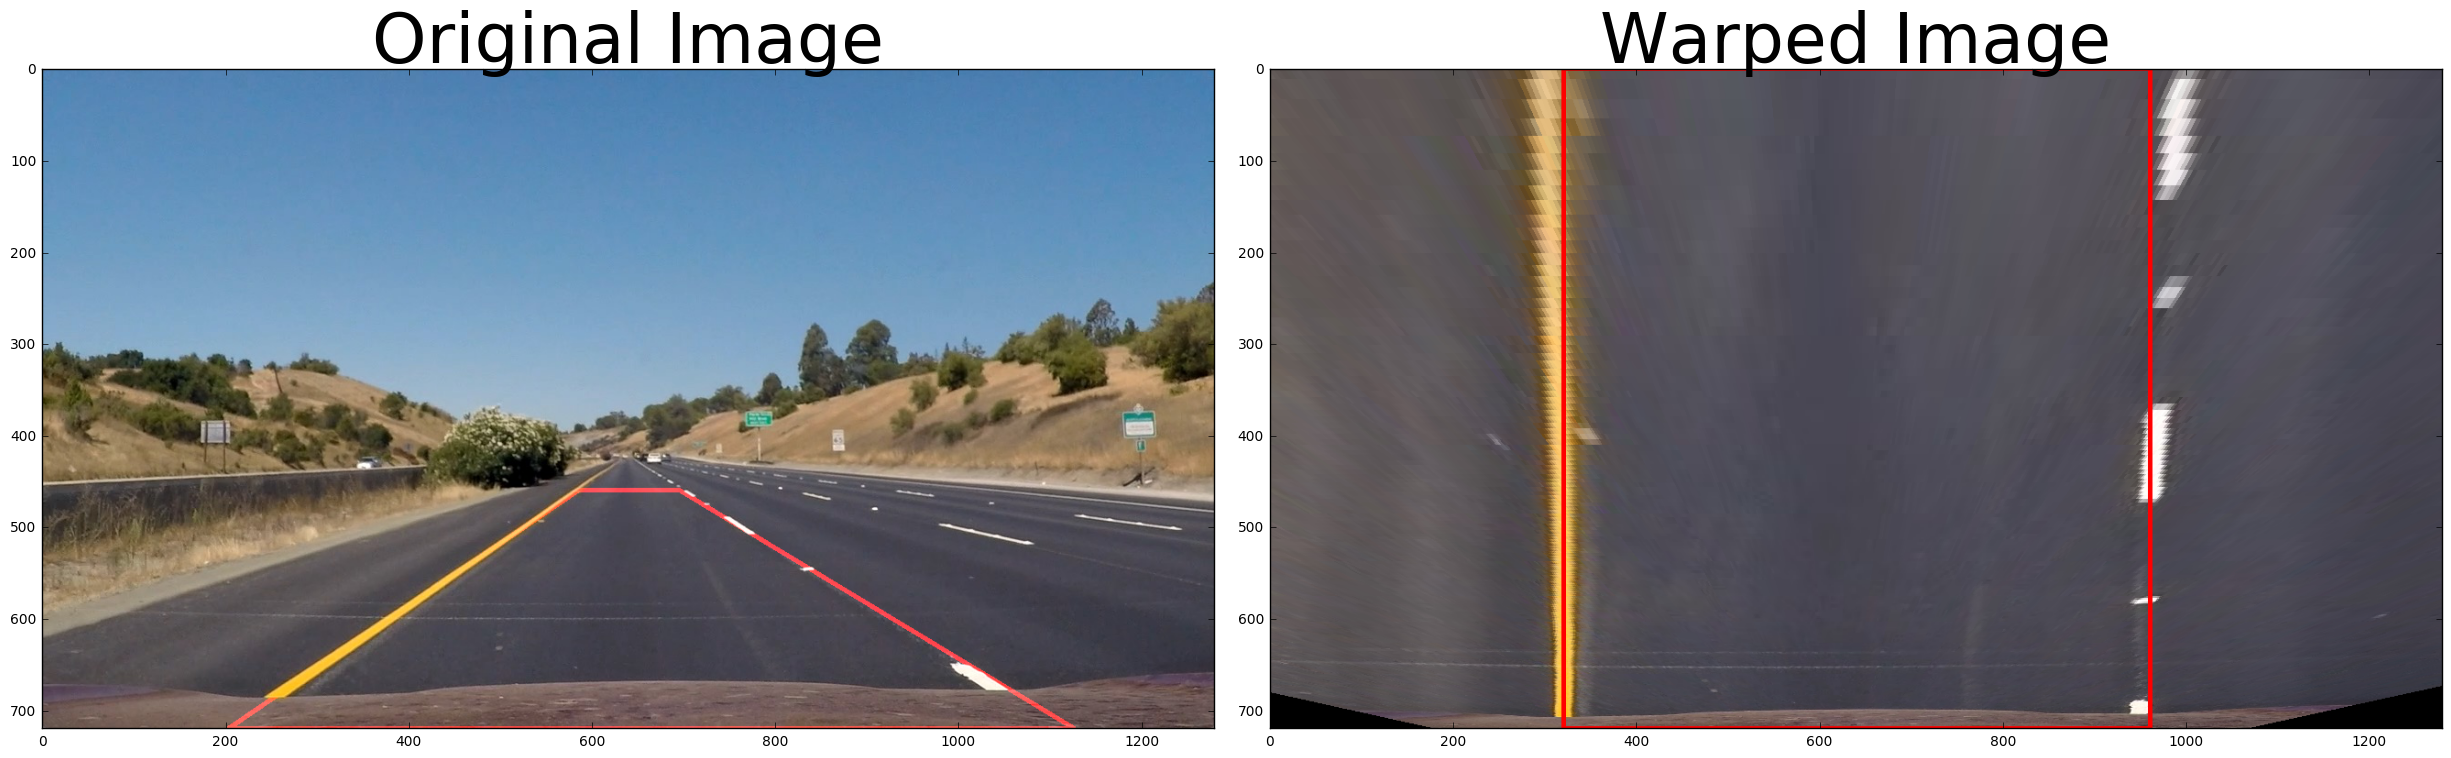

In [43]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
M, Minv = compute_perspective_matrix(img)

warped = apply_warp(img, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

blank = np.zeros_like(img)

cv2.polylines(blank, np.int32([src]), 1, 255, thickness=3)
result = cv2.addWeighted(img, 1, blank, 1., 0)

f.tight_layout()
ax1.imshow(result, cmap='gray')
ax1.set_title('Original Image', fontsize=50)


for x, y in dst:
    ax2.plot(x, y, '-')

cv2.polylines(warped, np.int32([dst]), 1, 255, thickness=3)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Detect lane pixels and fit function

All the code for the lane detection can be found in `lane_finding.py`. A Line() class is used to represent the lines detected, which is the output of the detect_lines() function. 

To detect the lane pixels, a histogram is computed to obtain the pixel distribution of the lower half of the image. The peaks of the histogram represent the starting points of the lines from the hood of the car. A sliding window is then gradually going up the image to obtain the center points of the pixels within a 100 pixel margin. We then fit a line from these obtained points using the polyfit() function. The left and right line and colored, along with a yellow line that shows the function that was obtained from the fit polynomial below. 

(720, 0)

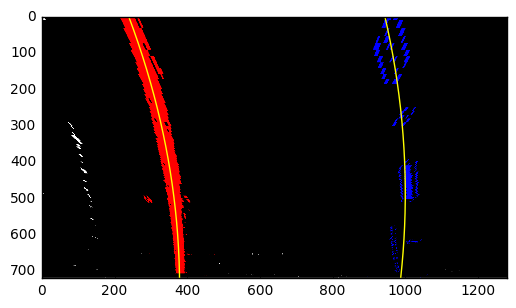

In [51]:
img = mpimg.imread('./test_images/test2.jpg')
binary_output = combine_thresh(img)

binary_warped = apply_warp(binary_output, M)

left_line, right_line = detect_lines_blind(binary_warped)

left_fit = left_line.current_fit
fity = left_line.ally
right_fit = right_line.current_fit

# Generate x and y values for plotting
fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

margin = 100

left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) 
    + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] - margin)) & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) 
    + left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin)))

right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) 
    + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] - margin)) & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) 
    + right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))


out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Once the lines are detected, we can use the previously detected lines as starting point for detecting the lines in the next images. Instead of using a sliding window, we use the fit of the last line and search within a margin of a 100 pixels as we go up the image. The search space is highlighted in green below

(720, 0)

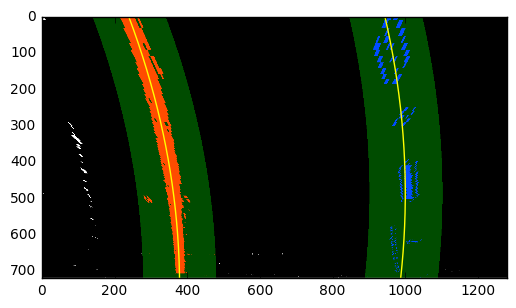

In [59]:
img = mpimg.imread('./test_images/test2.jpg')
binary_output = combine_thresh(img)
binary_warped = apply_warp(binary_output, M)

left_line, right_line = detect_lines(binary_warped, left_line, right_line)

margin = 100

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## 5. Warping the detected lane back and drawing on road

After detecting the line boundaries, we use the Minv matrix, which is the inverse matrix that we previously used to obtain the bird's eye view of the road. Also, we can draw the lane on the road with a polygon in green to highlight the current driving lane using the points from the 2 line fits.

The Line() class keeps track of the previous n (in this case 10) lines and averages them out to get a better x and fit. This is done in the smooth_fit() function of Line().

We can also compute the radius of curvature and the position of the line from the center of car. The function to obtain the radius of curvature used can be found [here](http://www.intmath.com/applications-differentiation/8-radius-curvature.php). We then have convert the values in x and y from pixel space to meters in real life. Averaging out the left and right curvatures give out to the overall radius of curvature of the road.

673.810023401 -2.7591428571428573


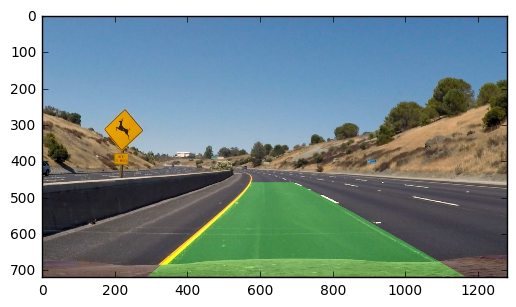

In [58]:
left_line.smooth_fit()
right_line.smooth_fit()

left_curverad = left_line.compute_radius_curvature()
right_curverad = right_line.compute_radius_curvature()
left_position = left_line.compute_position()
right_position = left_line.compute_position()

curvature = (left_curverad + right_curverad) / 2
position = left_position + right_position

print(curvature, position)

lane_img = draw_lanes(img, binary_warped, Minv, left_line, right_line)
plt.imshow(lane_img)

## 6. Putting it all together

A LaneDetector() class was created to simplify the pipeline. It puts together all the methods and techniques discussed above. It is first tested with the test images, then ran on the video inputs below.

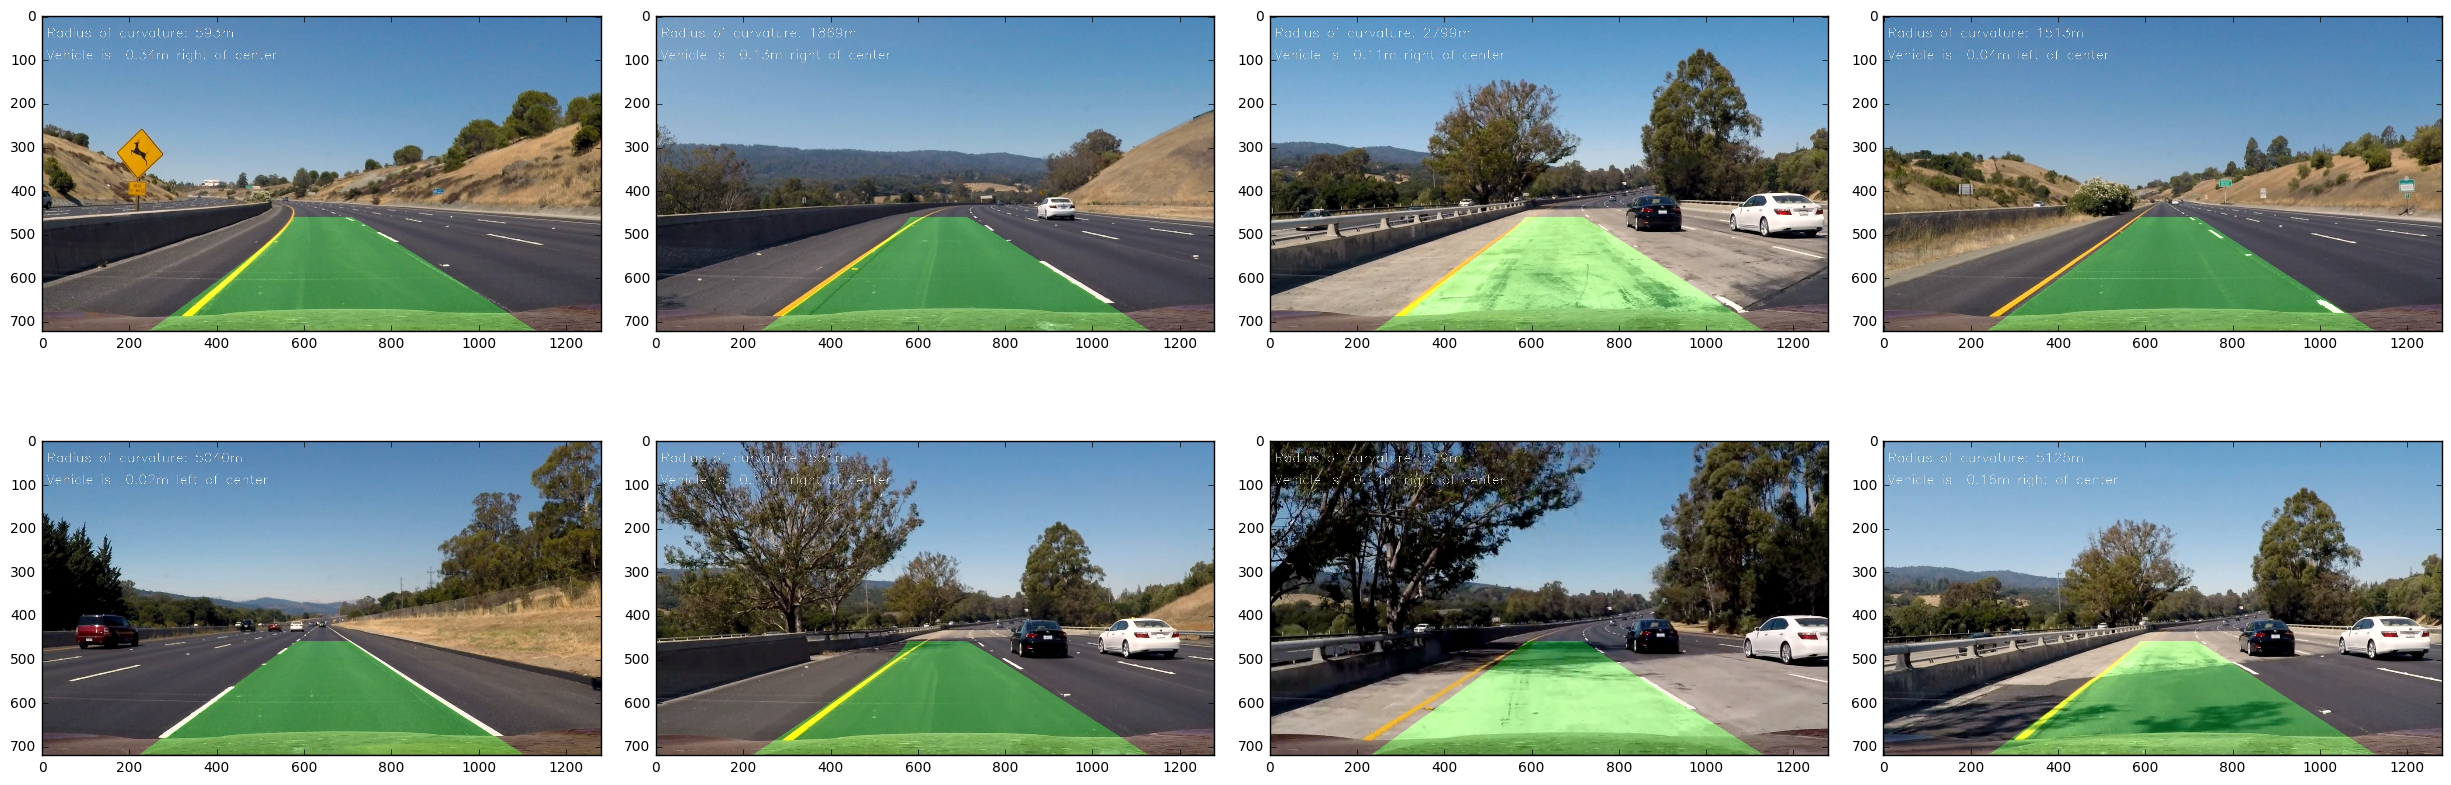

In [29]:
# Run the pipeline on the test images
images = glob.glob('./test_images/*.jpg')
lane_detector = LaneDetector()

for fname in images:

    img = mpimg.imread(fname)
    #print(fname)
    output_image = lane_detector.pipeline(img)
    mpimg.imsave('output_images/output_{}'.format(fname.split("/")[2]), output_image)
    
f, axarr = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()

output_images = glob.glob('./output_images/*.jpg')
out_imgs = [mpimg.imread(img) for img in output_images]

for i in range(2):
    for j in range(4):
        axarr[i, j].imshow(out_imgs[i * 4 + j])

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
lane_detector = LaneDetector()

project_output = 'harder_challenge_output.mp4'
clip = VideoFileClip('harder_challenge_video.mp4')
outclip = clip.fl_image(lane_detector.pipeline)
%time outclip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


100%|█████████▉| 1199/1200 [14:20<00:00,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

CPU times: user 34min 45s, sys: 12.8 s, total: 34min 58s
Wall time: 14min 21s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_output.mp4"))

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("challenge_output.mp4"))

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("harder_challenge_output.mp4"))

## 7. Discussion

One of the challenges of the project was the integration of all different components. Although individual parts work correctly, putting them together were not as straight forward.

One of the places my pipeline may have problems (as seen in the harder_challenge_output.mp4) is when lines are not detected because of lighting, cars and passengers obstructing the way. This can be overcome by running the sliding window to recompute the lines. A more thorough experimentation of the smoothing of past lines can also be used to not be affected as much by drastic changes in the road lines.

Additionally, having a more sophisticated binary thresholded image to detect the pixels from the line would prevent the line detection algorithm to fail due to different conditions.

Finally, the perspective transform is meant to be applied to road lines in front of the car, but when the car turns or changes lanes, the warped image may look strange, causing the detection to act strangely.